In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy.optimize import minimize, differential_evolution
import os
import src.fitting as fitting
import src.multielec_utils as mutils
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
dataset = "2021-05-27-0/data005/data005-all/"
electrical_path = "/Volumes/Analysis/" + dataset

In [3]:
vis_datapath = "/Volumes/Analysis/2021-05-27-0/kilosort_data001/data001"
vis_datarun = "data001"
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [4]:
patterns = np.array([2])
n = 595

In [5]:
all_elecs = []
neg_inds_total = 0
pos_inds_total = 0

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = (
        "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity/"
        + dataset
        + "p"
        + str(p)
        + "/"
    )

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(
            filepath
            + "gsort_tri_v2_n"
            + str(n)
            + "_p"
            + str(p)
            + "_k"
            + str(k)
            + ".pkl",
            "rb",
        ) as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["prob"]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]
    good_inds = np.where(triplet_probs > 0.5)[0]
    all_elecs.append(triplet_elecs)

    pos_inds_total += len(pos_inds)
    neg_inds_total += len(neg_inds)

Pattern 2


In [6]:
len(good_inds)

1123

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)

clb = plt.colorbar(scat)

In [ ]:
# Create a figure and a 3D Axes
fig = plt.figure()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    ax.scatter(amplitudes[:, 0][good_inds], 
               amplitudes[:, 1][good_inds],
               amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
    
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
# anim.save('/Volumes/Lab/Users/praful/thresh_surface_comp_p.gif', writer='imagemagick', fps=30)
plt.show()

In [7]:
pos_inds_total, neg_inds_total

(326, 392)

In [8]:
all_elecs_array = np.unique(np.array(all_elecs))

In [9]:
all_elecs_array

array([429, 438, 439], dtype=uint16)

In [10]:
X_pos = []
y_pos = []

X_neg = []
y_neg = []

trials_pos = []
trials_neg = []

In [11]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = (
        "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity/"
        + dataset
        + "p"
        + str(p)
        + "/"
    )

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(
            filepath
            + "gsort_tri_v2_n"
            + str(n)
            + "_p"
            + str(p)
            + "_k"
            + str(k)
            + ".pkl",
            "rb",
        ) as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["prob"]
            triplet_trials[k] = prob_dict["num_trials"]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]

    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)

    y = triplet_probs[pos_inds]
    X = amplitudes[pos_inds]
    trials = triplet_trials[pos_inds]
    X_pos_p = np.zeros((len(pos_inds), len(all_elecs_array)))
    X_pos_p[:, elec_inds] = X
    X_pos.append(X_pos_p)
    y_pos.append(y)
    trials_pos.append(trials)

    y = triplet_probs[neg_inds]
    X = amplitudes[neg_inds]
    trials = triplet_trials[neg_inds]
    X_neg_p = np.zeros((len(neg_inds), len(all_elecs_array)))
    X_neg_p[:, elec_inds] = X
    X_neg.append(X_neg_p)
    y_neg.append(y)
    trials_neg.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[neg_inds])
    print(X_neg_p)
    print(y)
    print(trials)

Pattern 2
[429 438 439]
[429 439 438]
[0 2 1]
[[-0.65625 -0.09375 -0.09375]
 [-0.46875 -0.28125 -0.09375]
 [-0.46875 -0.46875 -0.09375]
 ...
 [-0.28125 -1.78125 -1.78125]
 [-0.46875 -1.78125 -1.78125]
 [-1.59375 -1.78125 -1.78125]]
[[-0.65625 -0.09375 -0.09375]
 [-0.46875 -0.09375 -0.28125]
 [-0.46875 -0.09375 -0.46875]
 ...
 [-0.28125 -1.78125 -1.78125]
 [-0.46875 -1.78125 -1.78125]
 [-1.59375 -1.78125 -1.78125]]
[0.95       0.35       0.4        0.7        0.85       0.5
 0.15       0.55       0.2        0.15       0.2        0.8
 0.15       0.3        0.2        0.3        0.65       0.4
 0.15       0.15       0.10526316 0.89473684 0.31578947 0.94736842
 0.47368421 0.89473684 0.26315789 0.94736842 0.15789474 0.36842105
 0.21052632 0.94736842 0.10526316 0.73684211 0.26315789 0.89473684
 0.68421053 0.10526316 0.10526316 0.10526316 0.63157895 0.89473684
 0.21052632 0.26315789 0.15789474 0.73684211 0.42105263 0.68421053
 0.21052632 0.84210526 0.52631579 0.36842105 0.21052632 0.52631579


In [42]:
all_amps_neg = np.vstack(X_neg)
all_probs_neg = np.hstack(y_neg)
trials_neg = np.hstack(trials_neg)

In [43]:
all_amps_pos = np.vstack(X_pos)
all_probs_pos = np.hstack(y_pos)
trials_pos = np.hstack(trials_pos)

In [44]:
all_amps_neg

array([[-0.65625, -0.09375, -0.09375],
       [-0.46875, -0.09375, -0.28125],
       [-0.46875, -0.09375, -0.46875],
       ...,
       [-0.28125, -1.78125, -1.78125],
       [-0.46875, -1.78125, -1.78125],
       [-1.59375, -1.78125, -1.78125]])

In [45]:
all_amps_pos.shape, all_probs_pos.shape, trials_pos.shape

((326, 3), (326,), (326,))

In [46]:
train_amps_pos, test_amps_pos, train_probs_pos, test_probs_pos, train_trials_pos, _ = train_test_split(all_amps_pos, all_probs_pos, trials_pos, test_size=0.2)
train_amps_neg, test_amps_neg, train_probs_neg, test_probs_neg, train_trials_neg, _ = train_test_split(all_amps_neg, all_probs_neg, trials_neg, test_size=0.2)

In [57]:
degree = 6
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_neg, train_trials_neg, train_amps_neg, degree
)

In [58]:
multi_X.shape, multi_y.shape

((5997, 84), (5997,))

In [59]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [60]:
multi_weights

array([-1.04801932e+02, -3.94406120e+02, -1.39214084e+02, -6.62347698e+01,
       -5.21154236e+02, -5.03209941e+02, -3.01512871e+02, -4.87712182e+00,
       -1.39520469e+02,  1.83743833e+02, -3.80574806e+02, -6.45079608e+02,
       -1.76885740e+02, -3.68290411e+01, -5.26300133e+02,  8.60429702e+00,
        5.41630950e+01, -4.09023018e+01,  8.69628062e+01,  3.30547421e+02,
       -1.64607064e+02, -3.81211135e+02, -6.31548776e+01, -2.19722491e+02,
       -3.04536391e+02,  1.08505622e+02,  1.98076059e+02, -1.54729075e+02,
       -2.27507088e+02,  6.53353479e+01,  1.36793446e+01, -6.76255229e+00,
        5.26130316e+01,  1.66787616e+02,  2.37445132e+02, -3.35671484e+01,
       -1.38084159e+02, -1.14852729e+01, -7.21443872e+01, -7.44183558e+01,
        3.11410316e+01, -2.40980919e+01, -9.96201252e+01, -3.63044724e+01,
        6.72437850e+01,  1.04937741e+02,  4.50975161e+01, -9.67068929e+01,
       -4.59340518e+01,  2.10641165e+01, -5.85445399e+00, -1.65019274e+01,
        1.62947770e+01,  

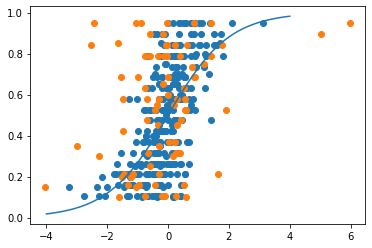

In [61]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_neg)
test_y = test_probs_neg

train_X = poly.fit_transform(train_amps_neg)
train_y = train_probs_neg

plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))

In [32]:
degree = 3
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_pos, train_trials_pos, train_amps_pos, degree
)

In [33]:
multi_X.shape, multi_y.shape

((4978, 20), (4978,))

In [34]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [35]:
multi_weights

array([-0.37155408,  0.49344965,  6.05179407, -4.50690078,  0.41363965,
       -0.86563097,  0.06355543, -8.17457607,  1.4221996 ,  4.28221898,
       -0.04512272, -1.13590195,  0.35615391,  1.69401603, -0.15363224,
       -0.54155457,  2.31003924,  0.57859668, -0.84287754, -1.11514321])

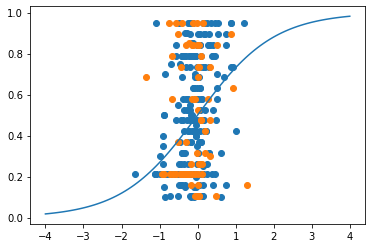

In [36]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_pos)
test_y = test_probs_pos

train_X = poly.fit_transform(train_amps_pos)
train_y = train_probs_pos

plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))